In [220]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import re
%matplotlib inline

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

## Functions

In [221]:
# I use this for all of the later iterations, since we're running all of the same steps.
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

def train_run_score_model(df,df_target_col,train_data):
    target_data = df[df_target_col]
    bnb = BernoulliNB()
    bnb.fit(train_data, target_data)
# Classify, storing the result in a new variable.
    y_pred = bnb.predict(train_data)

    print("Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:")
    cross_val_array = cross_val_score(bnb, train_data, target_data, cv=10)
    print(cross_val_array)
    print("Further analysis of model fit:")
    analyze_model_fit(df,df_target_col,y_pred)

In [222]:
def build_keyword_variables(df,kw_dict):
    for keyword, keypattern in kw_dict.items():
# In the guided example, this had spaces hard-coded around the keyword.
# I want more flexibility--I will use regular expressions instead of just words here
        df[str(keyword)] = df['sentiment'].str.contains(keypattern,case=False)
    
# Flip the results for keywords whose descriptions start with "no "
    for no_keyword in [x for x in kw_dict if re.search('no ',x)]:
        print("Flipping results for variable: {}".format(no_keyword))
        df[str(no_keyword)] = (df[str(no_keyword)] == False)
    return df

In [223]:
def analyze_model_fit(input_df,input_col,target_series):
# Calculate the accuracy of your model here.
    mismatches = (input_df[input_col] != target_series).sum()
    total = len(target_series)
    accuracy = ((total - mismatches) / total) * 100
    print("Accuracy = {}".format(accuracy))
    
# Build your confusion matrix and calculate sensitivity and specificity here.
    correct_positives = input_df.loc[(input_df[input_col] == True) & (target_series == True),input_col].count()
    false_negatives = input_df.loc[(input_df[input_col] == True) & (target_series == False),input_col].count()
    false_positives = input_df.loc[(input_df[input_col] == False) & (target_series == True),input_col].count()
    correct_negatives = input_df.loc[(input_df[input_col] == False) & (target_series == False),input_col].count()

    total_negatives = np.array([correct_negatives,false_positives])
    total_positives = np.array([false_negatives,correct_positives])

    confusion_matrix = np.array([total_negatives,
                                 total_positives])
    print("Confusion matrix:\n", confusion_matrix)

    sensitivity = (correct_positives / sum(total_positives)) * 100
    specificity = (correct_negatives / sum(total_negatives)) * 100

    print("Sensitivity = {}".format(sensitivity))
    print("Specificity = {}".format(specificity))

In [224]:
def create_wordcloud(series,**kwargs):
    bgcolor = kwargs.get('bgcolor','orange')

# Generate a word cloud image
    wordcloud = WordCloud(background_color=bgcolor).generate(" ".join(series))
    plt.figure(figsize=(15,10))
# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [225]:
# Perform the same basic steps to set up a dataframe, for a new iteration of the sentiment classifier
def new_iteration(df,kw_dict):
    df_new = df.copy(deep=True)
# Transform the positive column to True/False
    df_new['positive'] = (df_new['positive'] == 1)
    build_keyword_variables(df_new,kw_dict)
    return df_new

## My classifier from the previous challenge was trained to analyze Yelp reviews. 

I need to somehow create five different versions of this classifier now, and evaluate the differences between them?

In [275]:
yelp_df = pd.read_csv('yelp_labelled.txt',delimiter='\t',header=None,names=['sentiment','positive'])
# Create a static copy we can refer to through each iteration.
# deep=True means we're not just creating a shallow link to yelp_df.
yelp_df_save = yelp_df.copy(deep=True)

In [227]:
yelp_df.describe()

,positive
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [228]:
# Transform the positive column to True/False
yelp_df['positive'] = (yelp_df['positive'] == 1)
# Note that if you run this cell a second time everything will become false.
# So... Don't.

### Choose some words to help train the model to recognize positive reviews.

I eyeballed the sentiments and chose these words for the first iteration or two.

In [229]:
# I'm using a dict so I can define patterns but still have clean variable names in the dataframe
kw_dict = {'love': ' love[ dl]*',
           'great': ' great',
           'best': 'best ',
           'fast': ' fast',
           'friendly': 'friendly',
           'amazing': 'amazing',
           'awesome': 'awesome',
           'excellent': 'excellent',
           'good': ' good ',
           'glad': 'glad',
           'prompt': 'prompt',
           'delicious': 'delicious',
           'nice': 'nice',
           'refreshing': 'refreshing',
           'enjoy': ' enjoy[ed]*',
           'moist': 'moist',
           'yummy': 'yummy',
           'a lot': 'a lot',
           'recommend': 'recommend',
# We will flip the results (True<=>False) of columns whose descriptions start with "no ",
# so they help us understand when words suggest a negative review, instead of positive.
#           'no good': 'not.*?good', # Possibly covered by the "no not" keyword below?
           'no at best': 'at best',
           'no but': ' but ',
           'no no': ' no ',
           'no not': 'not ',
           'no problem': ' problem',
          }

In [230]:
yelp_df = build_keyword_variables(yelp_df,kw_dict)
yelp_df.head()

Flipping results for variable: no at best
Flipping results for variable: no but
Flipping results for variable: no no
Flipping results for variable: no not
Flipping results for variable: no problem


,sentiment,positive,love,great,best,fast,friendly,amazing,awesome,excellent,good,glad,prompt,delicious,nice,refreshing,enjoy,moist,yummy,a lot,recommend,no at best,no but,no no,no not,no problem
0,Wow... Loved this place.,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
1,Crust is not good.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True
2,Not tasty and the texture was just nasty.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
4,The selection on the menu was great and so were the prices.,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True


In [231]:
yelp_df.describe(exclude=['object'])

,positive,love,great,best,fast,friendly,amazing,awesome,excellent,good,glad,prompt,delicious,nice,refreshing,enjoy,moist,yummy,a lot,recommend,no at best,no but,no no,no not,no problem
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
freq,500,968,950,978,995,973,976,988,990,944,998,998,976,973,999,989,997,996,993,982,995,944,981,887,999


### Verify that the keywords are largely independent.

The heatmap should show very little correlation between the variables we created based on our keywords.

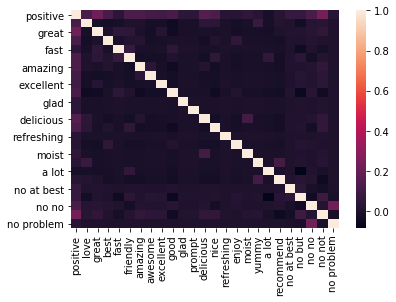

In [232]:
sns.heatmap(yelp_df.corr())

### Create training and target data for the model, and run it.

In [233]:
data = yelp_df[kw_dict.keys()]
target = yelp_df['positive']

In [234]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [235]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

### NEW: Cross-validation. Break the training data into folds, and train against each fold, instead of the entire set together at once. Compare the accuracy of each fold--ideally they are the same.

In [236]:
cross_val_score(bnb, data, target, cv=10)

array([0.7 , 0.69, 0.68, 0.71, 0.73, 0.67, 0.76, 0.72, 0.69, 0.79])

The initial run looks like this:
    
`array([0.7 , 0.69, 0.68, 0.71, 0.73, 0.67, 0.76, 0.72, 0.69, 0.79])`

These values fluctuate noticeably between folds--up to 10%. This is an indication that the model may be overfitting.

### NEW: Further analysis of the output. What is this model good at, and where can we improve it?

In [237]:
analyze_model_fit(yelp_df,'positive',y_pred)

Accuracy = 72.1
Confusion matrix:
 [[472  28]
 [251 249]]
Sensitivity = 49.8
Specificity = 94.39999999999999


__In the original run of this analysis:__ 
    * This iteration of the model is really good at identifying negative sentiments (94.4%), but there is a lot of room for improvement in recognizing positive sentiments (49.8%, or slightly under half correctly recognized).
    * The confusion matrix suggests we're great at recognizing negative reviews, but terrible at recognizing positive reviews--251 times, we incorrectly identified a negative review as a positive one (false negatives).

In [238]:
# Add the classification from the model to a new column so we can browse the output
yelp_df['nb_positive'] = y_pred

### Updated question: What are the false negatives?

In [239]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 279


In [240]:
false_negatives_df = yelp_df.loc[(yelp_df['positive'] != yelp_df['nb_positive']) & (yelp_df['positive'] == True),['positive','nb_positive','sentiment']]
false_negatives_df

,positive,nb_positive,sentiment
13,True,False,"I tried the Cape Cod ravoli, chicken,with cranberry...mmmm!"
22,True,False,Service is also cute.
23,True,False,I could care less... The interior is just beautiful.
24,True,False,So they performed.
25,True,False,That's right....the red velvet cake.....ohhh this stuff is so good.
30,True,False,"Also there are combos like a burger, fries, and beer for 23 which is a decent deal."
32,True,False,I found this place by accident and I could not be happier.
34,True,False,"Overall, I like this place a lot."
35,True,False,The only redeeming quality of the restaurant was that it was very inexpensive.
38,True,False,My first visit to Hiro was a delight!


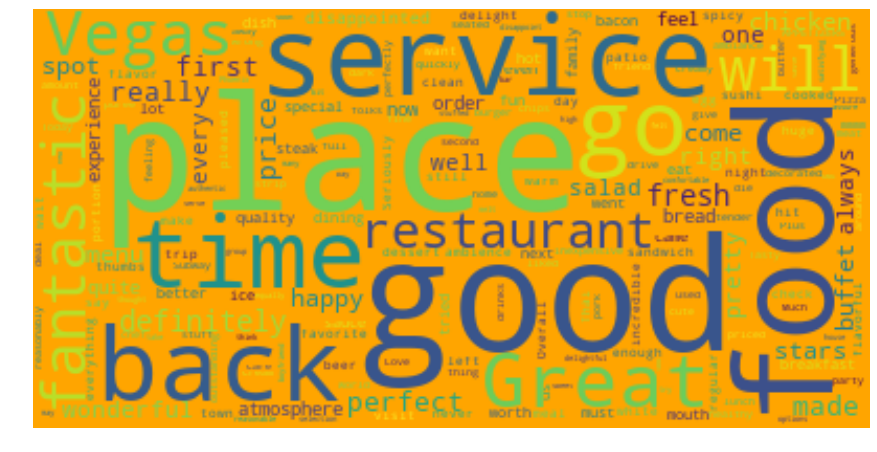

In [241]:
create_wordcloud(false_negatives_df['sentiment'])

## Second iteration: add some keywords from the wordcloud.

In [242]:
# Try adding some new keywords. Does that improve results?
kw_dict = {'love': ' love[ dl]*',
           'great': ' great',
           'best': 'best ',
           'fast': ' fast',
           'friendly': 'friendly',
           'amazing': 'amazing',
           'awesome': 'awesome',
           'excellent': 'excellent',
           'good': ' good ',
           'glad': 'glad',
           'prompt': 'prompt',
           'delicious': 'delicious',
           'nice': 'nice',
           'refreshing': 'refreshing',
           'enjoy': ' enjoy[ed]*',
           'moist': 'moist',
           'yummy': 'yummy',
#           'a lot': 'a lot',
           'recommend': 'recommend',
# I added these terms based on the wordcloud I created, based on false negatives:
           'place': 'place',
           'service': 'service',
#           'will': ' will ',
           'definitely': ' definitely ',
#           'back': ' back ',
#           'go': ' go ',
# We will flip the results of columns whose descriptions start with "no ",
# so they help us understand when words are NOT present.
#           'no good': 'not.*?good', # Possibly covered by the "no not" keyword below?
           'no at best': 'at best',
           'no but': ' but ',
           'no no': ' no ',
           'no not': 'not ',
           'no problem': ' problem',
          }

In [243]:
# New copy of the raw df
yelp_2_df = new_iteration(yelp_df_save,kw_dict)

Flipping results for variable: no at best
Flipping results for variable: no but
Flipping results for variable: no no
Flipping results for variable: no not
Flipping results for variable: no problem


In [244]:
yelp_2_df.columns

Index(['sentiment', 'positive', 'love', 'great', 'best', 'fast', 'friendly',
       'amazing', 'awesome', 'excellent', 'good', 'glad', 'prompt',
       'delicious', 'nice', 'refreshing', 'enjoy', 'moist', 'yummy',
       'recommend', 'place', 'service', 'definitely', 'no at best', 'no but',
       'no no', 'no not', 'no problem'],
      dtype='object')

In [245]:
yelp_df_save.columns

Index(['sentiment', 'positive'], dtype='object')

In [246]:
train_run_score_model(yelp_2_df,'positive',yelp_2_df[kw_dict.keys()])

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.7  0.67 0.68 0.71 0.74 0.66 0.75 0.67 0.69 0.78]
Further analysis of model fit:
Accuracy = 71.89999999999999
Confusion matrix:
 [[471  29]
 [252 248]]
Sensitivity = 49.6
Specificity = 94.19999999999999


First run results:
```
Accuracy = 72.1
Confusion matrix:
 [[472  28]
 [251 249]]
Sensitivity = 49.8
Specificity = 94.39999999999999
```
So this second run is barely any different.

positive      1.000000
no not        0.236897
great         0.220239
delicious     0.156813
amazing       0.130677
friendly      0.129563
nice          0.129563
love          0.125000
no no         0.124520
best          0.122713
good          0.121781
awesome       0.110208
excellent     0.100504
no at best    0.070888
no but        0.069589
moist         0.054855
glad          0.044766
prompt        0.044766
fast          0.042533
yummy         0.031686
no problem    0.031639
refreshing    0.031639
recommend     0.030086
enjoy         0.028763
service       0.028534
place         0.019331
definitely    0.017023
Name: positive, dtype: float64

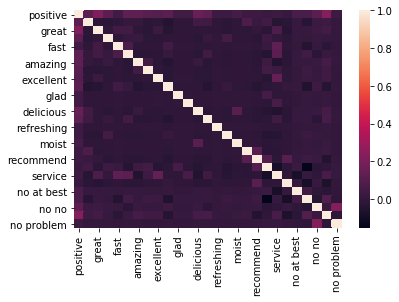

In [247]:
yelp2_corr = yelp_2_df.corr()
sns.heatmap(yelp2_corr)
yelp2_corr['positive'].sort_values(ascending=False)

In [248]:
# Get a count of the most frequent words. My mentor made me aware of "stopwords", so I'm going to eliminate those
# from the results and see what's left.
yelp2_word_freq = yelp_2_df.loc[yelp_2_df['positive'] == True]['sentiment'].str.split(expand=True).stack().value_counts()
yelp2_word_freq.head()

and    218
the    214
was    137
I      113
a      107
dtype: int64

In [249]:
yelp2_word_freq.describe()

count    1693.000000
mean     3.038984   
std      10.686302  
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      218.000000 
dtype: float64

In [250]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [251]:
# Not a perfect filter, but I can skim past a few words that didn't match because of case.
# So these are the most popular words in positive sentiments. I want to build a dictionary based on them.
goodwords = {}
for goodword in [x for x in yelp2_word_freq.index if x.lower() not in stopwords]:
    goodwords[goodword] = yelp2_word_freq[goodword]
goodwords

{'good': 42,
 'place': 39,
 'great': 37,
 'food': 37,
 'really': 21,
 'time': 19,
 'Great': 19,
 'service': 19,
 'friendly': 16,
 'like': 16,
 'good.': 15,
 'also': 15,
 'back': 14,
 'nice': 14,
 'love': 13,
 'first': 12,
 'go': 12,
 'place.': 12,
 'restaurant': 12,
 'Service': 11,
 'best': 11,
 '-': 11,
 'made': 9,
 'staff': 9,
 'definitely': 9,
 'service.': 9,
 'always': 9,
 'get': 8,
 'even': 8,
 'happy': 8,
 "I'm": 8,
 'here.': 8,
 'ever': 8,
 'pretty': 8,
 'Vegas': 8,
 'could': 8,
 'came': 8,
 'fresh': 8,
 'menu': 8,
 'server': 8,
 'excellent': 8,
 'delicious.': 7,
 'amazing': 7,
 'Best': 7,
 'food,': 7,
 'chicken': 7,
 'steak': 7,
 "I've": 7,
 'every': 7,
 'want': 7,
 'one': 7,
 'delicious!': 7,
 'awesome': 7,
 '5': 7,
 'amazing.': 7,
 'say': 7,
 'food.': 7,
 'us': 7,
 'Food': 7,
 'come': 7,
 'good,': 6,
 'spicy': 6,
 'recommend': 6,
 'still': 6,
 'Good': 6,
 'sauce': 6,
 'staff.': 6,
 'wonderful': 6,
 'loved': 6,
 'Vegas.': 6,
 'pizza': 6,
 'great.': 6,
 'order': 6,
 'experience

## Third iteration: start over, with a fresh list of the most frequent non-stopword words from reviews with positive sentiments. None of my "no" words are included in the keyword list.

In [252]:
# Here are the most popular words among the positive sentiments, that are not also stopwords.
# I'm going to try removing the "no" words this time, and see how just a good list of 
# positive words works.
kw_dict = {
           'good': ' good ',
           'place': ' place',
           'great': ' great',
           'food': 'food',
           'really': ' really ',
           'time': ' time ',
           'service': ' service',
           'friendly': ' friendly ',
           'like': ' like ',
           'also': ' also ',
           'back': ' back ',
           'nice': ' nice',
           'love': ' love[ dl]*',
           'first': ' first ',
           'go': ' go ',
           'staff': 'staff',
           'definitely': ' definitely ',   
           'always': ' always ',
           'happy': ' happy ',
           'best': ' best ',
           'fast': ' fast',
           'pretty': ' pretty ',
           'fresh': ' fresh ',
           'menu': ' menu ',
           'server': ' server ',
           'excellent': ' excellent ',
           'delicious.': ' delicious ',
           'amazing': ' amazing ',
          }

In [253]:
# New copy of the raw df
yelp_3_df = new_iteration(yelp_df_save,kw_dict)

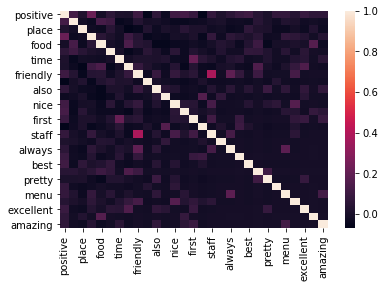

In [254]:
yelp3_corr = yelp_3_df.corr()
sns.heatmap(yelp3_corr)

In [255]:
train_run_score_model(yelp_3_df,'positive',yelp_3_df[kw_dict.keys()])

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.64 0.65 0.67 0.67 0.7  0.66 0.66 0.63 0.61 0.7 ]
Further analysis of model fit:
Accuracy = 66.4
Confusion matrix:
 [[449  51]
 [285 215]]
Sensitivity = 43.0
Specificity = 89.8


False positives are still our biggest problem by far, so let's add the most frequent negative words into the mix and see if that helps drag these numbers back up.

In [256]:
# Get a count of the most frequent words. My mentor made me aware of "stopwords", so I'm going to eliminate those
# from the results and see what's left.
yelp3_word_freq = yelp_3_df.loc[yelp_3_df['positive'] == False]['sentiment'].str.split(expand=True).stack().value_counts()
#yelp3_word_freq.head()
badwords = {}
for badword in [x for x in yelp3_word_freq.index if x.lower() not in stopwords]:
    badwords[badword] = yelp3_word_freq[badword]
badwords

{'food': 43,
 'place': 37,
 'like': 29,
 'go': 25,
 'service': 22,
 'back': 20,
 'would': 19,
 "don't": 19,
 'time': 16,
 'much': 15,
 'got': 15,
 'never': 15,
 'good': 14,
 'minutes': 14,
 "wasn't": 13,
 "I've": 13,
 'back.': 13,
 "won't": 13,
 'ever': 13,
 'going': 13,
 'think': 13,
 'one': 12,
 'eat': 12,
 'came': 12,
 "I'm": 12,
 'food.': 11,
 'get': 11,
 'again.': 11,
 'it.': 11,
 '-': 10,
 'really': 10,
 'even': 9,
 "didn't": 9,
 'bad': 9,
 'better': 9,
 'another': 9,
 'wait': 8,
 'us': 8,
 'know': 8,
 'could': 8,
 'times': 8,
 'pretty': 8,
 'place.': 8,
 'quality': 8,
 'probably': 8,
 'disappointed': 7,
 'bit': 7,
 'slow': 7,
 'worst': 7,
 'chicken': 7,
 'took': 7,
 'feel': 7,
 'good.': 7,
 'way': 7,
 'give': 7,
 'service.': 7,
 'coming': 7,
 '&': 6,
 'around': 6,
 'take': 6,
 'ordered': 6,
 'felt': 6,
 'definitely': 6,
 'burger': 6,
 'said': 6,
 'best.': 6,
 'made': 6,
 'next': 6,
 'also': 6,
 'waited': 6,
 'want': 6,
 'getting': 6,
 "can't": 5,
 'say': 5,
 'bad.': 5,
 'went': 

In [257]:
# Here are the most popular words among the positive sentiments, that are not also stopwords.
kw_dict = {
           'good': ' good ',
           'place': ' place',
           'great': ' great',
           'food': 'food',
           'really': ' really ',
           'time': ' time ',
           'service': ' service',
           'friendly': ' friendly ',
           'like': ' like ',
           'also': ' also ',
           'back': ' back ',
           'nice': ' nice',
           'love': ' love[ dl]*',
           'first': ' first ',
           'go': ' go ',
           'staff': 'staff',
           'definitely': ' definitely ',   
           'always': ' always ',
           'happy': ' happy ',
           'best': ' best ',
           'fast': ' fast',
           'pretty': ' pretty ',
           'fresh': ' fresh ',
           'menu': ' menu ',
           'server': ' server ',
           'excellent': ' excellent ',
           'delicious.': ' delicious ',
           'amazing': ' amazing ',
# The most frequent negative words. If a word is on both the positive and negative list,
# let's try leaving it on the positive list, and see how that looks. In the next iteration
# we can either move it to the negative list, or remove it as a key word altogether.
           'no would': ' would ',
           "no don't": " don't ",
           'no much': ' much ',
           'no never': ' never ',
           'no minutes': ' minutes ',
           "no wasn't": " wasn't ",
           'no ever even': ' eve[nr] ',
           'no think': ' think ',
           "no didn't": " didn't ",
           'no bad': ' bad ',
           'no another': ' another ',
           'no wait': ' wait ',
          }

In [258]:
# New copy of the raw df
yelp_4_df = new_iteration(yelp_df_save,kw_dict)

Flipping results for variable: no would
Flipping results for variable: no don't
Flipping results for variable: no much
Flipping results for variable: no never
Flipping results for variable: no minutes
Flipping results for variable: no wasn't
Flipping results for variable: no ever even
Flipping results for variable: no think
Flipping results for variable: no didn't
Flipping results for variable: no bad
Flipping results for variable: no another
Flipping results for variable: no wait


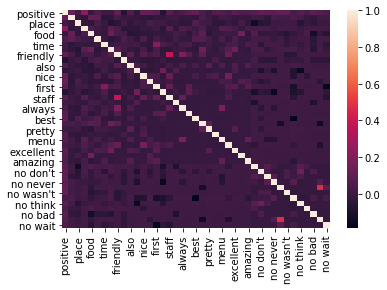

In [259]:
yelp4_corr = yelp_4_df.corr()
sns.heatmap(yelp4_corr)

In [260]:
train_run_score_model(yelp_4_df,'positive',yelp_4_df[kw_dict.keys()])

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.64 0.63 0.67 0.68 0.71 0.63 0.67 0.56 0.58 0.68]
Further analysis of model fit:
Accuracy = 67.0
Confusion matrix:
 [[452  48]
 [282 218]]
Sensitivity = 43.6
Specificity = 90.4


The cross-validation numbers aren't as high as the third iteration. The accuracy, sensitivity, and specificity are marginally better--one percent or less. 

## Fifth iteration: take a word off the positive list if it also appeared frequently on the negative list. See if that helps reduce the number of false positives we're seeing.

In [280]:
# Here are the most popular words among the positive sentiments, that are not also stopwords.
# If a word was also frequent in negative sentiments, I commented it out.
kw_dict = {
#           'good': ' good ',
#           'place': ' place',
           'great': ' great',
#           'food': 'food',
#           'really': ' really ',
#           'time': ' time ',
#           'service': ' service',
           'friendly': ' friendly ',
#           'like': ' like ',
           'also': ' also ',
#           'back': ' back ',
           'nice': ' nice',
           'love': ' lov[ei][ dl]*',
           'first': ' first ',
#           'go': ' go ',
#           'staff': 'staff', # This was found to have some correlation with the 'friendly' keyword
           'definitely': ' definitely ',   
           'always': ' always ',
           'happy': ' happy ',
           'best': ' best ',
           'fast': ' fast',
#           'pretty': ' pretty ',
           'fresh': ' fresh ',
           'menu': ' menu ',
           'server': ' server ',
           'excellent': ' excellent ',
           'delicious.': ' delicious ',
           'amazing': ' amazing ',
# The most frequent negative words. I added a few new ones, to see
# if we can also improve recognition of negative sentiments.
           'no would': ' would ',
           "no don't": " don't ",
           'no much': ' much ',
           'no never': ' never ',
           'no minutes': ' minutes ',
           "no wasn't": " wasn't ",
           'no ever even': ' eve[nr] ',
           'no think': ' think ',
           "no didn't": " didn't ",
           'no bad': ' bad ',
#           'no another': ' another ', # This was found to have some correlation with the 'no minutes' keyword
           'no wait': ' wait ',
           'no disappoint': ' disappoint',
           'no worst': ' worst ',
          }

In [281]:
# New copy of the raw df
yelp_5_df = new_iteration(yelp_df_save,kw_dict)

Flipping results for variable: no would
Flipping results for variable: no don't
Flipping results for variable: no much
Flipping results for variable: no never
Flipping results for variable: no minutes
Flipping results for variable: no wasn't
Flipping results for variable: no ever even
Flipping results for variable: no think
Flipping results for variable: no didn't
Flipping results for variable: no bad
Flipping results for variable: no wait
Flipping results for variable: no disappoint
Flipping results for variable: no worst


In [282]:
yelp_5_df.loc[yelp_5_df['no ever even'] == False,['sentiment','positive']]

,sentiment,positive
12,The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.,False
92,"Never been to Hard Rock Casino before, WILL NEVER EVER STEP FORWARD IN IT AGAIN!",False
120,I just don't know how this place managed to served the blandest food I have ever eaten when they are preparing Indian cuisine.,False
123,"The guys all had steaks, and our steak loving son who has had steak at the best and worst places said it was the best steak he's ever eaten.",True
261,"I have been in more than a few bars in Vegas, and do not ever recall being charged for tap water.",False
275,"I've had better, not only from dedicated boba tea spots, but even from Jenni Pho.",False
306,"Will never, ever go back.",False
321,"Also, the fries are without a doubt the worst fries I've ever had.",False
358,Best fish I've ever had in my life!,True
361,This is an Outstanding little restaurant with some of the Best Food I have ever tasted.,True


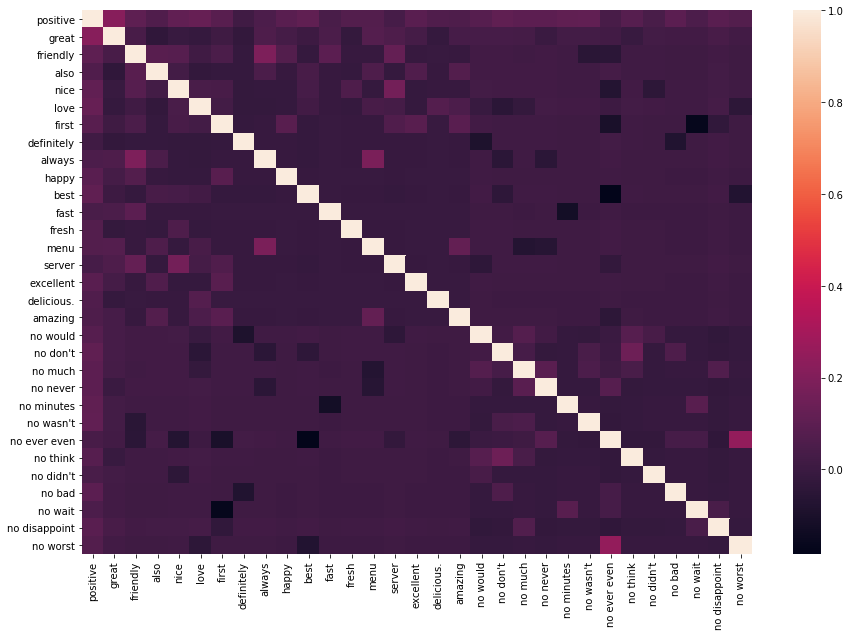

In [283]:
yelp5_corr = yelp_5_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(yelp5_corr)

In [284]:
yelp5_corr['positive'].sort_values(ascending=False)

positive         1.000000
great            0.220239
love             0.128753
no wasn't        0.114766
nice             0.113406
no minutes       0.110208
no don't         0.109079
best             0.106950
friendly         0.105302
no much          0.100564
no never         0.100000
no bad           0.095298
happy            0.089803
excellent        0.089803
no disappoint    0.089389
first            0.085113
no would         0.083267
no think         0.079697
menu             0.074121
fresh            0.074121
no worst         0.074121
delicious.       0.063372
also             0.062768
amazing          0.059972
always           0.055104
no wait          0.052943
no didn't        0.044141
fast             0.042533
no ever even     0.040825
server           0.036736
definitely       0.017023
Name: positive, dtype: float64

In [285]:
train_run_score_model(yelp_5_df,'positive',yelp_5_df[kw_dict.keys()])

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.65 0.59 0.65 0.62 0.7  0.61 0.68 0.61 0.64 0.7 ]
Further analysis of model fit:
Accuracy = 65.0
Confusion matrix:
 [[474  26]
 [324 176]]
Sensitivity = 35.199999999999996
Specificity = 94.8


The worst for false positives of the bunch. It brought the recognition of negative sentiments back up to the first iterations, at least. Okay, I'm done for now, but will ask my mentor for help.